In [1]:
import sys
sys.path.append("../src/")
sys.path.append("../src/AtomicH")

In [2]:
import elastic
import potentials
import constants
import spinexchange
import dipolelosses
import numpy as np
import pylab as plt
from dipolelosses import DipoleChannels
from spinexchange import SpinExChannels

In [3]:
k_A  = np.linspace(1e-4, 4*constants.hcInEVAngstrom, 200)
k_eV = k_A / constants.hcInEVAngstrom

r0       = 1e-9
intlimit = 100 * constants.BohrInAng/constants.hcInEVAngstrom
rhos     = np.linspace(r0, intlimit, 100)

muT = constants.TritiumConstants.mu

even_ls = np.arange(0, 16, 2)  

sigma_T_by_l = {}
sigma_T_total = np.zeros_like(k_A)  

for l in even_ls:
    sigma_T_partial = np.array([
        elastic.GetCrossSection(rhos, k, l, muT,
                                potentials.Silvera_Triplet, 'Radau')
        for k in k_A
    ])
    sigma_T_by_l[l] = sigma_T_partial
    sigma_T_total   += sigma_T_by_l[l]

In [4]:
def total_sigma_for_potential(pot_obj, k_grid_A, rhos, mu, integrator='Radau'):
    sigma_total = np.zeros_like(k_grid_A, dtype=float)
    for l in even_ls:
        
        sigma_l = np.array([elastic.GetCrossSection(rhos, k, l, mu, pot_obj, integrator)
            for k in k_grid_A])
        sigma_total += sigma_l
        
    return sigma_total

sigmaT_raw   = {}
sigmaT_ratio = {}

for pot_key, pot in potentials.Triplets.items():
    sigmaT_raw[pot_key] = total_sigma_for_potential(pot, k_A, rhos, muT)

for pot_key, sig in sigmaT_raw.items():
    sigmaT_ratio[pot_key] = sig / sigma_T_total

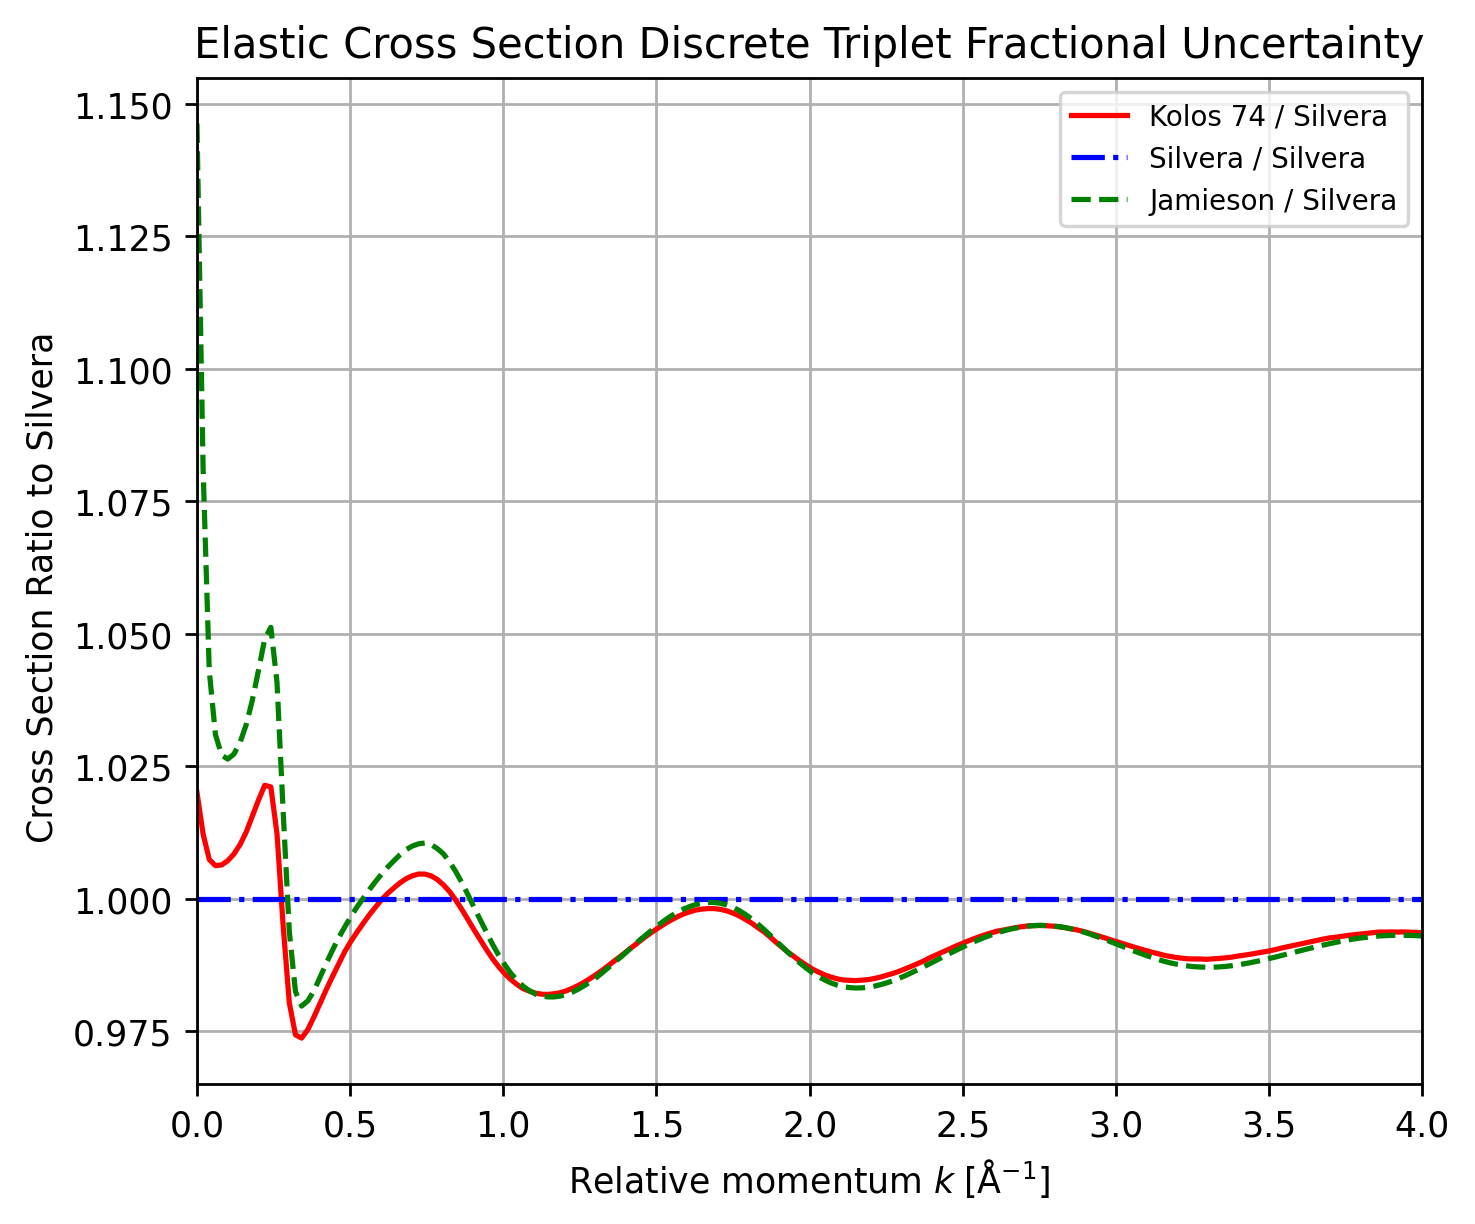

Kolos 74 / Silvera — mean ratio: 0.9926, std: 0.0079
Silvera / Silvera — mean ratio: 1.0000, std: 0.0000
Jamieson / Silvera — mean ratio: 0.9957, std: 0.0177


In [5]:
colors    = ['red', 'blue', 'green', 'orange', 'dimgrey', 'purple', 'brown', 'teal']
linetypes = ['-', '-.', '--', ':']

plt.figure(figsize=(6,5), dpi=250)
for i, pot_key in enumerate(potentials.Triplets.keys()):
    sig_ratio = sigmaT_ratio[pot_key]
    plt.plot(k_eV,sig_ratio,
        linetypes[i % len(linetypes)],color=colors[i % len(colors)],label=f"{pot_key} / {'Silvera'}")

plt.xlabel(r'Relative momentum $k\;[\mathrm{\AA}^{-1}]$')
plt.ylabel("Cross Section Ratio to Silvera ")
plt.xlim(0, 4)
plt.title("Elastic Cross Section Discrete Triplet Fractional Uncertainty")
plt.grid(True, which='both')
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

for pot_key in potentials.Triplets.keys():
    mean_ratio = float(np.mean(sigmaT_ratio[pot_key]))
    std_ratio  = float(np.std(sigmaT_ratio[pot_key]))
    print(f"{pot_key} / Silvera — mean ratio: {mean_ratio:.4f}, std: {std_ratio:.4f}")

In [6]:
def Potential_Perturbation(R):
    x = R * constants.hcInEVAngstrom / 4.16
    return (1 + .001*x) * potentials.Silvera_Triplet(R)

sigma_T_total_potential_perturb = total_sigma_for_potential(Potential_Perturbation, k_A, rhos, muT)

Mean ratio: 1.0014
Standard deviation: 0.0037


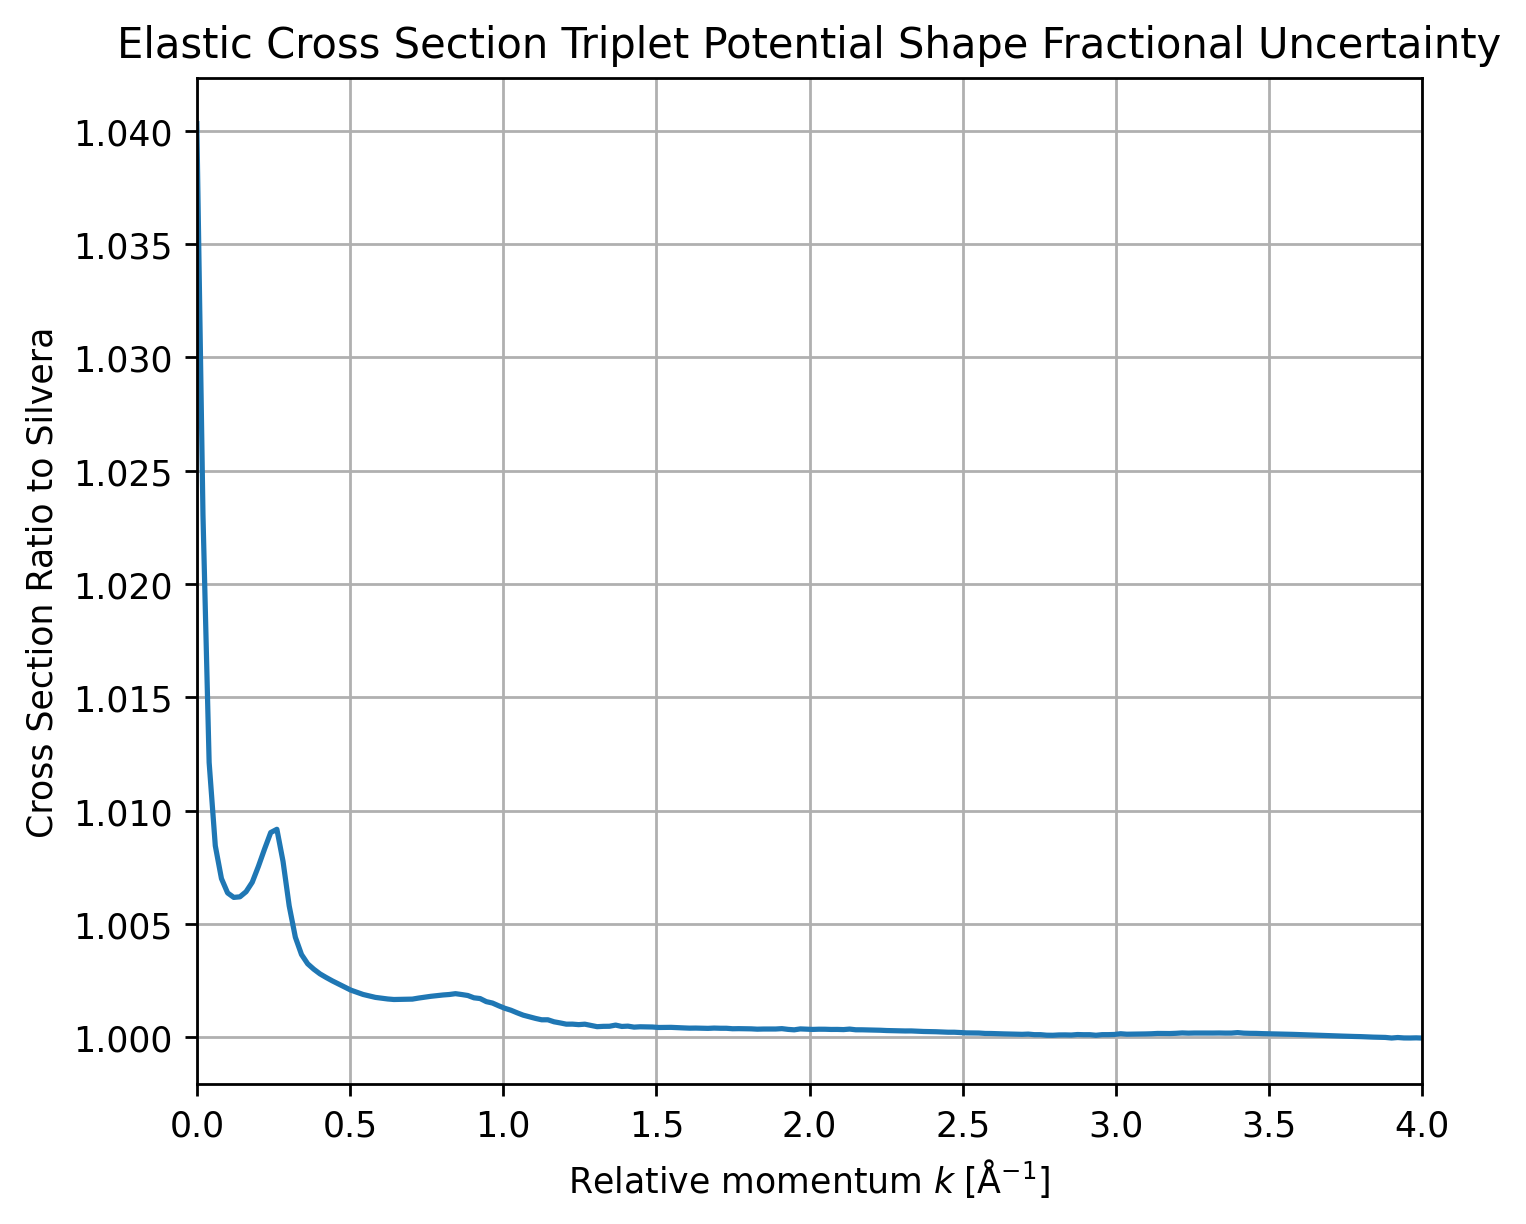

In [7]:
plt.figure(figsize=(6,5), dpi=250)
plt.plot(k_eV, sigma_T_total_potential_perturb / sigma_T_total)
plt.xlabel(r'Relative momentum $k\;[\mathrm{\AA}^{-1}]$')
plt.ylabel("Cross Section Ratio to Silvera")
plt.xlim(0, 4)
plt.title("Elastic Cross Section Triplet Potential Shape Fractional Uncertainty")
plt.grid(True, which='both')
plt.tight_layout()
plt.show

ratio = sigma_T_total_potential_perturb / sigma_T_total
mean_ratio = np.mean(ratio)
std_ratio  = np.std(ratio)

print(f"Mean ratio: {mean_ratio:.4f}")
print(f"Standard deviation: {std_ratio:.4f}")

In [8]:
sigmaT_raw_adiabatic = {}
sigmaT_ratio_adiabatic = {}

for pot_key, pot in potentials.TripletsT.items():
    sigmaT_raw_adiabatic[pot_key] = total_sigma_for_potential(pot, k_A, rhos, muT)

for pot_key in sigmaT_raw_adiabatic:
    sigmaT_ratio_adiabatic[pot_key] = sigmaT_raw_adiabatic[pot_key] / sigmaT_raw[pot_key]

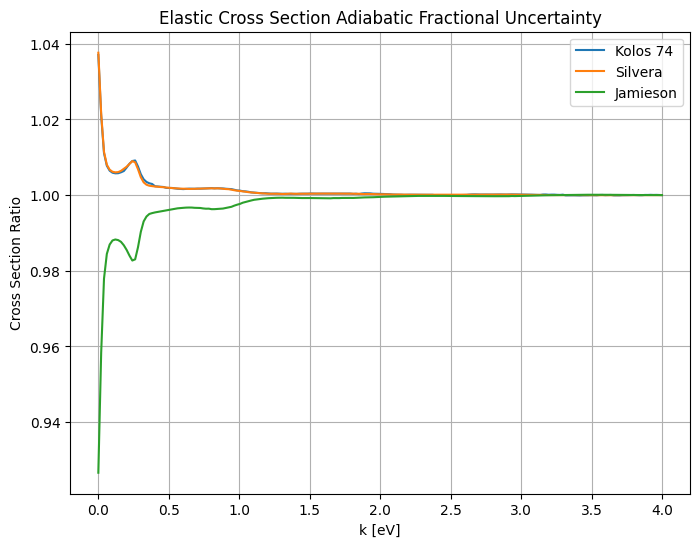

Kolos 74: mean = 1.0013, std = 0.0035
Silvera: mean = 1.0013, std = 0.0035
Jamieson: mean = 0.9975, std = 0.0069


In [9]:
plt.figure(figsize=(8,6))

for pot_key, ratio in sigmaT_ratio_adiabatic.items():
    plt.plot(k_eV, ratio, label=pot_key)

plt.xlabel("k [eV]")
plt.ylabel("Cross Section Ratio")
plt.title("Elastic Cross Section Adiabatic Fractional Uncertainty")
plt.legend()
plt.grid(True)
plt.show()

for pot_key, ratio in sigmaT_ratio_adiabatic.items():
    mean_ratio = np.mean(ratio)
    std_ratio  = np.std(ratio)
    print(f"{pot_key}: mean = {mean_ratio:.4f}, std = {std_ratio:.4f}")

In [10]:
extrapolation_potentials = {"Jamieson_Triplet_HFD": potentials.Jamieson_Triplet_HFD,
                            "Jamieson_Triplet_VDW": potentials.Jamieson_Triplet_VDW,}

sigmaT_raw_extrapolation = {}
sigmaT_ratio_extrapolation = {}

for pot_key, pot in extrapolation_potentials.items():
    sigmaT_raw_extrapolation[pot_key] = total_sigma_for_potential(pot, k_A, rhos, muT)

for pot_key, sigma_raw in sigmaT_raw_extrapolation.items():
    sigmaT_ratio_extrapolation[pot_key] = sigma_raw / sigmaT_raw_extrapolation["Jamieson_Triplet_HFD"]

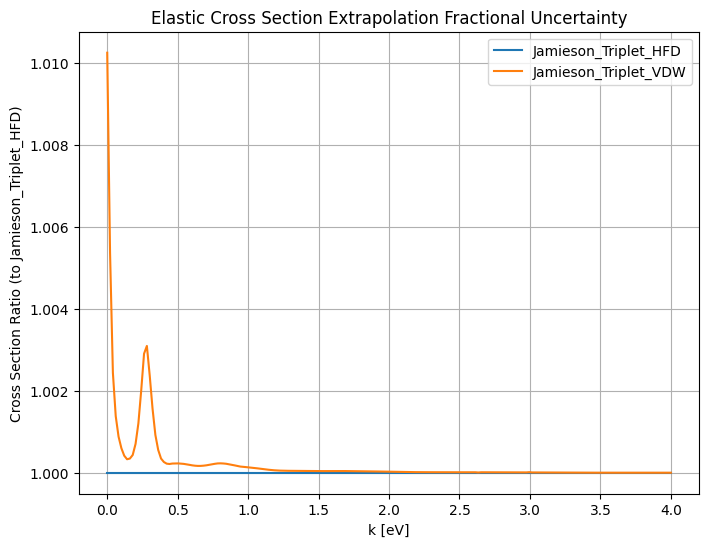

Jamieson_Triplet_HFD: mean = 1.0000, std = 0.0000
Jamieson_Triplet_VDW: mean = 1.0002, std = 0.0009


In [11]:
plt.figure(figsize=(8,6))
for pot_key, ratio in sigmaT_ratio_extrapolation.items():
    plt.plot(k_eV, ratio, label=pot_key)
plt.xlabel("k [eV]")
plt.ylabel("Cross Section Ratio (to Jamieson_Triplet_HFD)")
plt.title("Elastic Cross Section Extrapolation Fractional Uncertainty")
plt.legend()
plt.grid(True)
plt.show()

for pot_key, ratio in sigmaT_ratio_extrapolation.items():
    mean_ratio = np.mean(ratio)
    std_ratio = np.std(ratio)
    print(f"{pot_key}: mean = {mean_ratio:.4f}, std = {std_ratio:.4f}")

In [12]:
amuT = constants.TritiumConstants.mu + constants.meeV/2
sigmaT_raw_atomic = total_sigma_for_potential(pot, k_A, rhos, amuT)
sigmaT_ratio_atomic = sigmaT_raw_atomic / sigma_T_total

/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_8996/3684332351.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


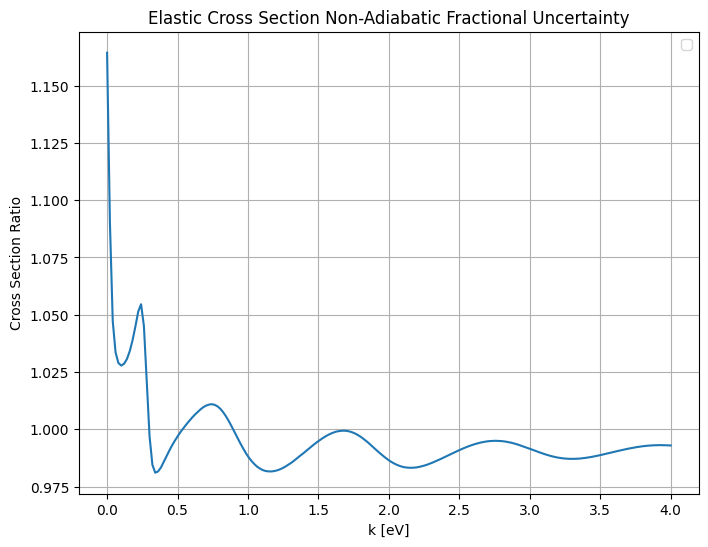

σT_ratio_atomic: mean = 0.9961, std = 0.0190


In [13]:
plt.figure(figsize=(8,6))
plt.plot(k_eV, sigmaT_ratio_atomic)
plt.xlabel("k [eV]")
plt.ylabel("Cross Section Ratio")
plt.title("Elastic Cross Section Non-Adiabatic Fractional Uncertainty")
plt.legend()
plt.grid(True)
plt.show()

mean_val = np.mean(sigmaT_ratio_atomic)
std_val  = np.std(sigmaT_ratio_atomic)

print(f"σT_ratio_atomic: mean = {mean_val:.4f}, std = {std_val:.4f}")

In [14]:
potT = potentials.Silvera_Triplet

B_values = np.logspace(-3, 1, 50)
T = 5e-4
rhos = np.linspace(1e-9, 0.75, 2000)

G_factors_rawDip = {}
G_factor_ratiosDip = {}

base_key = "Silvera"
base_potential = potentials.Triplets[base_key]


base_losses_by_channel = {}
for c in DipoleChannels:
    base_losses_by_channel[str(c)] = np.array([dipolelosses.GetGFactor(c, B, constants.TritiumConstants(), T, base_potential, rhos)for B in B_values])

/Users/tikitorch/AtomicHScattering/examples/../src/AtomicH/dipolelosses.py:66: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Integral = quad(Integrand, rhos[0], rhos[-1])[0] / (P1 * P2)
/Users/tikitorch/AtomicHScattering/examples/../src/AtomicH/dipolelosses.py:66: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  Integral = quad(Integrand, rhos[0], rhos[-1])[0] / (P1 * P2)


In [15]:
for pot_key, pot in potentials.Triplets.items():
    G_factors_rawDip[pot_key] = {}
    G_factor_ratiosDip[pot_key] = {}

    for c in DipoleChannels:
        channel_str = str(c)
        losses = np.array([dipolelosses.GetGFactor(c, B, constants.TritiumConstants(), T, pot, rhos)for B in B_values])
        G_factors_rawDip[pot_key][channel_str] = losses
        G_factor_ratiosDip[pot_key][channel_str] = losses / base_losses_by_channel[channel_str]


=== Kolos 74 / Silvera (Dipole) ===
Channel 1 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 1.0213, std = 0.0121
Channel 2 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 1.0192, std = 0.0106
Channel 3 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'd'}): mean = 1.0192, std = 0.0109
Channel 4 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'c'}): mean = 1.0091, std = 0.0031
Channel 5 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'd'}): mean = 1.0074, std = 0.0029


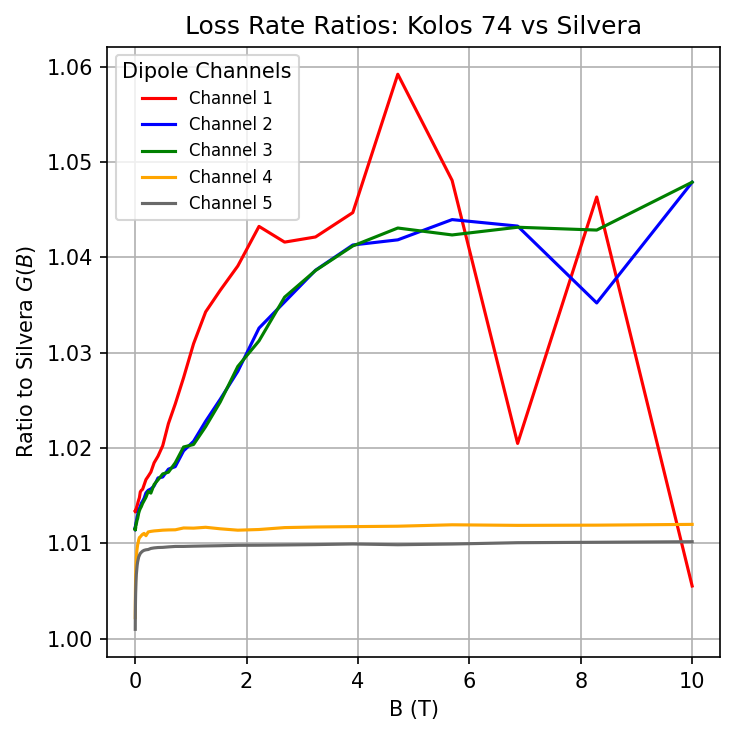


=== Silvera / Silvera (Dipole) ===
Channel 1 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 1.0000, std = 0.0000
Channel 2 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 1.0000, std = 0.0000
Channel 3 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'd'}): mean = 1.0000, std = 0.0000
Channel 4 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'c'}): mean = 1.0000, std = 0.0000
Channel 5 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'd'}): mean = 1.0000, std = 0.0000


/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_8996/2453290432.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Dipole Channels", fontsize=8)


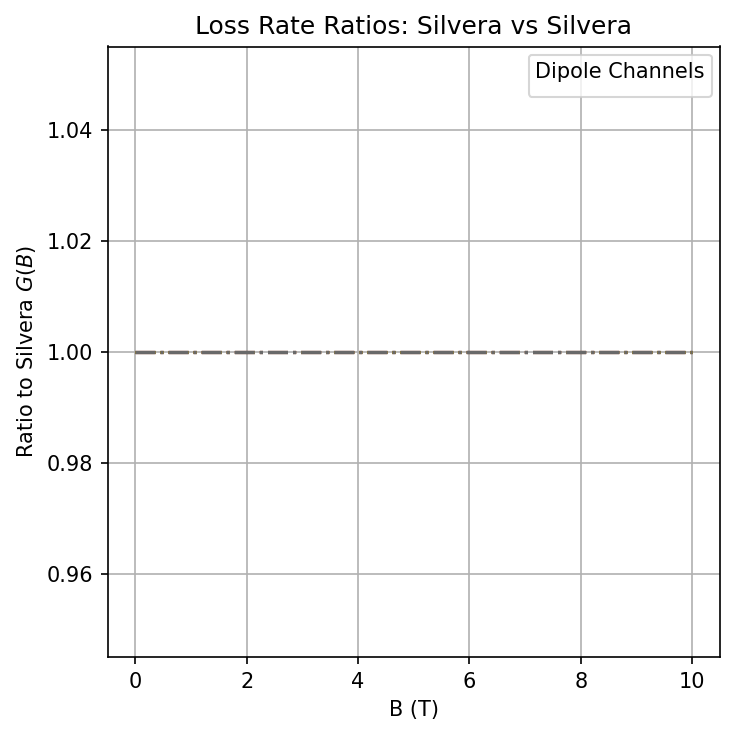


=== Jamieson / Silvera (Dipole) ===
Channel 1 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 1.1126, std = 0.0229
Channel 2 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 1.1051, std = 0.0255
Channel 3 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'd'}): mean = 1.1044, std = 0.0261
Channel 4 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'c'}): mean = 1.0628, std = 0.0213
Channel 5 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'd'}): mean = 1.0512, std = 0.0203


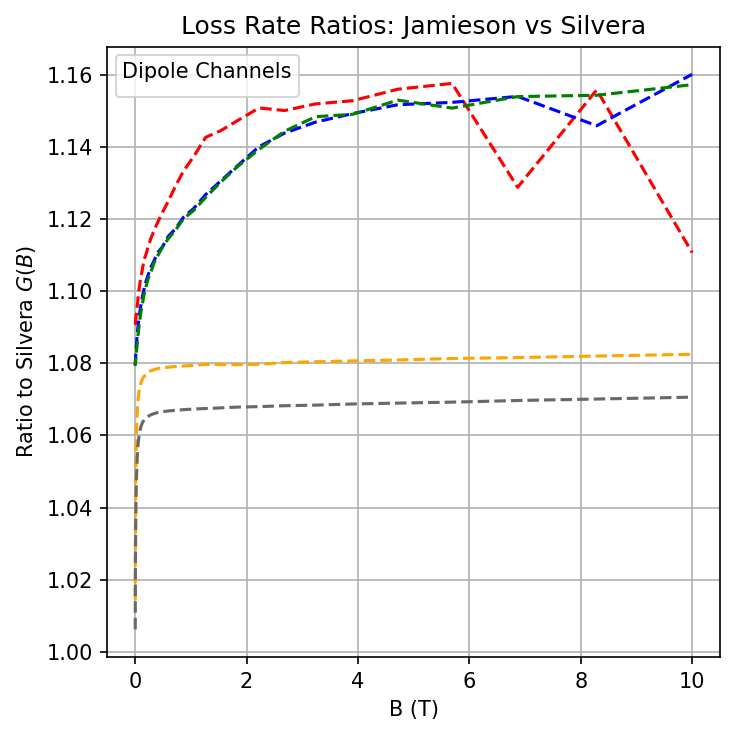

In [19]:
colors = ['red', 'blue', 'green', 'orange', 'dimgrey']
linetypes = ['-', '-.', '--', ':']

for pi, pot_key in enumerate(potentials.Triplets.keys()):
    print(f"\n=== {pot_key} / {base_key} (Dipole) ===")
    plt.figure(figsize=(5, 5), dpi=150)

    for ci, c in enumerate(DipoleChannels):
        channel_str = str(c)
        ratios = np.asarray(G_factor_ratiosDip[pot_key][channel_str], dtype=float)
        ratios[~np.isfinite(ratios)] = np.nan  

        mean_ratio = np.nanmean(ratios)
        std_ratio  = np.nanstd(ratios)

        print(f"Channel {ci+1} ({channel_str}): "f"mean = {mean_ratio:.4f}, std = {std_ratio:.4f}")

        label = f"Channel {ci+1}" if pi == 0 else None  
        plt.plot(B_values,ratios,
                 linetypes[pi % len(linetypes)],
                 color=colors[ci % len(colors)],
                 label=label)

    plt.xlabel("B (T)")
    plt.ylabel(f"Ratio to {base_key} $G(B)$")
    plt.title(f"Loss Rate Ratios: {pot_key} vs {base_key}")
    plt.grid(True, which='both')
    plt.legend(title="Dipole Channels", fontsize=8)
    plt.tight_layout()
    plt.show()

In [26]:
label = 'Dip_Trip'  
G_factors_raw_perturb   = {label: {}}   
G_factor_ratios_perturb = {label: {}}   

for c in DipoleChannels:
    channel_str = str(c)
    losses = np.asarray([
        dipolelosses.GetGFactor(c, B, constants.TritiumConstants(), T,Potential_Perturbation, rhos, lin=0, lout=2)
            for B in B_values], dtype=float)

    G_factors_raw_perturb[label][channel_str]   = losses
    G_factor_ratios_perturb[label][channel_str] = losses / base_losses_by_channel[channel_str]



=== Dip_Trip: Potential_Perturbation / Base (Dipole) ===
Channel 1 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 1.0291, std = 0.0038
Channel 2 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 1.0273, std = 0.0043
Channel 3 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'd'}): mean = 1.0271, std = 0.0044
Channel 4 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'c'}): mean = 1.0175, std = 0.0059
Channel 5 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'd'}): mean = 1.0143, std = 0.0056


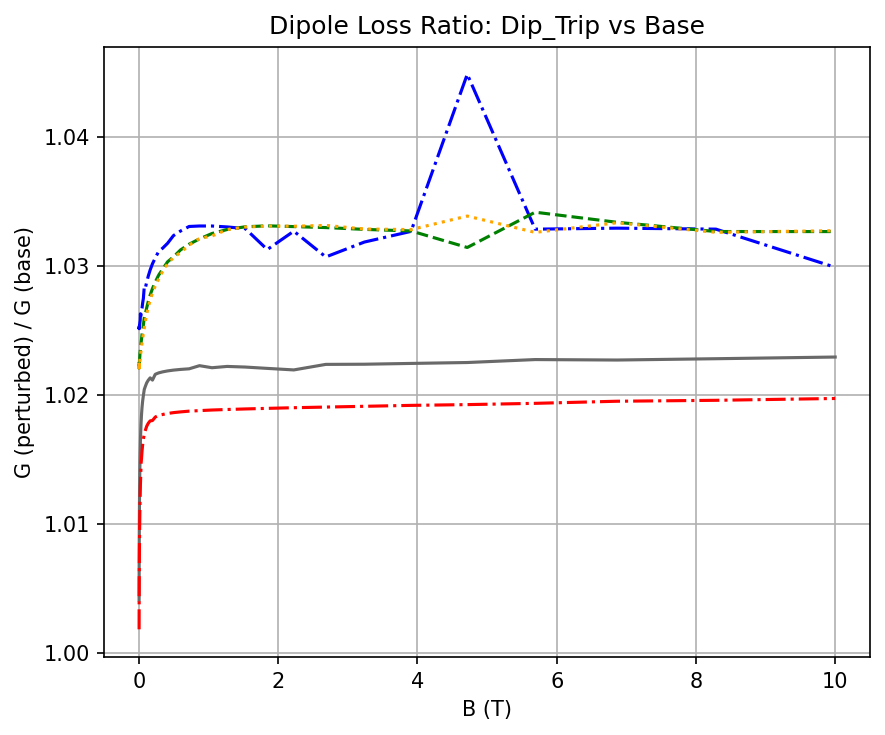

In [28]:
print(f"\n=== {label}: Potential_Perturbation / Base (Dipole) ===")
for i, (channel_str, ratio_obj) in enumerate(G_factor_ratios_perturb[label].items(), start=1):
    ratios = np.asarray(ratio_obj, dtype=float)
    ratios[~np.isfinite(ratios)] = np.nan  

    mean_ratio = np.nanmean(ratios)
    std_ratio  = np.nanstd(ratios)
    print(f"Channel {i} ({channel_str}): mean = {mean_ratio:.4f}, std = {std_ratio:.4f}")

plt.figure(figsize=(6,5), dpi=150)
for i, (channel_str, ratio_obj) in enumerate(G_factor_ratios_perturb[label].items(), start=1):
    ratios = np.asarray(ratio_obj, dtype=float)
    ratios[~np.isfinite(ratios)] = np.nan
    plt.plot(
        B_values, ratios,
        linestyle=linetypes[i % len(linetypes)],
        color=colors[i % len(colors)],
        label=f"Channel {channel_str}"
    )

plt.xlabel("B (T)")
plt.ylabel("G (perturbed) / G (base)")
plt.title(f"Dipole Loss Ratio: {label} vs Base")
plt.grid(True, which='both')
#plt.legend(title="Dipole Channels", fontsize=8, ncol=2)
plt.tight_layout()
plt.show()


In [30]:
G_factors_raw_adiabaticDip = {}
G_factor_ratios_adiabaticDip = {}

for pot_key, pot in potentials.TripletsT.items():
    G_factors_raw_adiabaticDip[pot_key] = {}
    G_factor_ratios_adiabaticDip[pot_key] = {}

    for c in DipoleChannels:
        channel_str = str(c)
        losses = np.array([dipolelosses.GetGFactor(c, B, constants.TritiumConstants(), T, pot, rhos)for B in B_values])
        G_factors_raw_adiabaticDip[pot_key][channel_str] = losses
        G_factor_ratios_adiabaticDip[pot_key][channel_str] = losses / G_factors_rawDip[pot_key][channel_str]


=== Kolos 74 / Silvera (Dipole) ===
Channel 1 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 1.0269, std = 0.0046
Channel 2 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 1.0253, std = 0.0042
Channel 3 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'd'}): mean = 1.0250, std = 0.0042
Channel 4 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'c'}): mean = 1.0162, std = 0.0054
Channel 5 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'd'}): mean = 1.0133, std = 0.0052


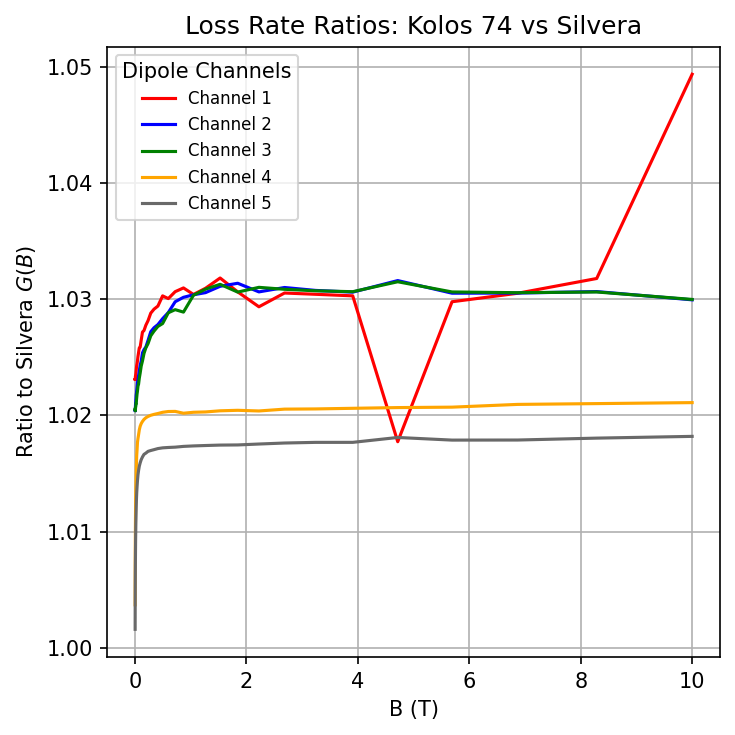


=== Silvera / Silvera (Dipole) ===
Channel 1 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 1.0266, std = 0.0065
Channel 2 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 1.0255, std = 0.0042
Channel 3 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'd'}): mean = 1.0254, std = 0.0043
Channel 4 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'c'}): mean = 1.0164, std = 0.0055
Channel 5 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'd'}): mean = 1.0134, std = 0.0053


/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_8996/1485925632.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Dipole Channels", fontsize=8)


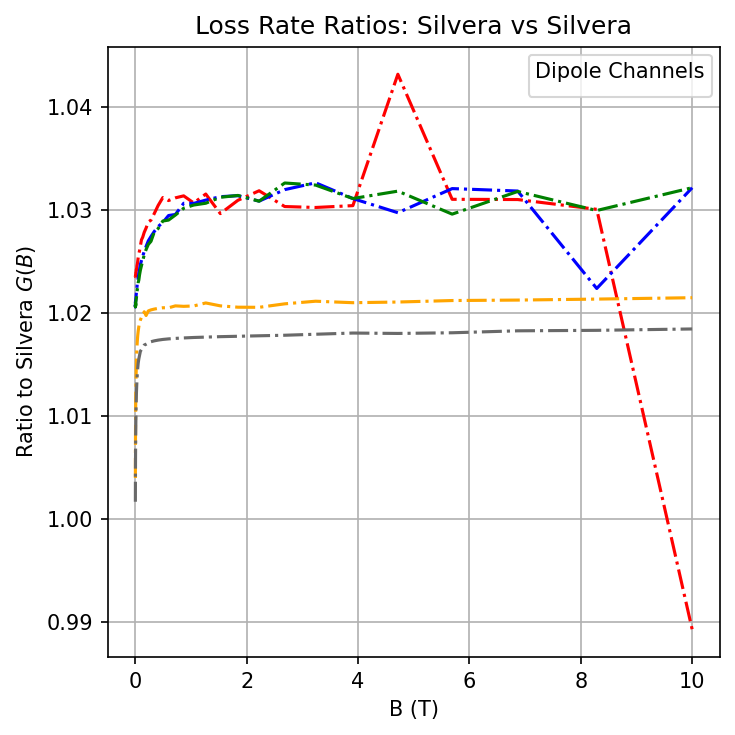


=== Jamieson / Silvera (Dipole) ===
Channel 1 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 0.9459, std = 0.0060
Channel 2 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 0.9490, std = 0.0078
Channel 3 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'd'}): mean = 0.9494, std = 0.0080
Channel 4 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'c'}): mean = 0.9668, std = 0.0109
Channel 5 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'd'}): mean = 0.9727, std = 0.0106


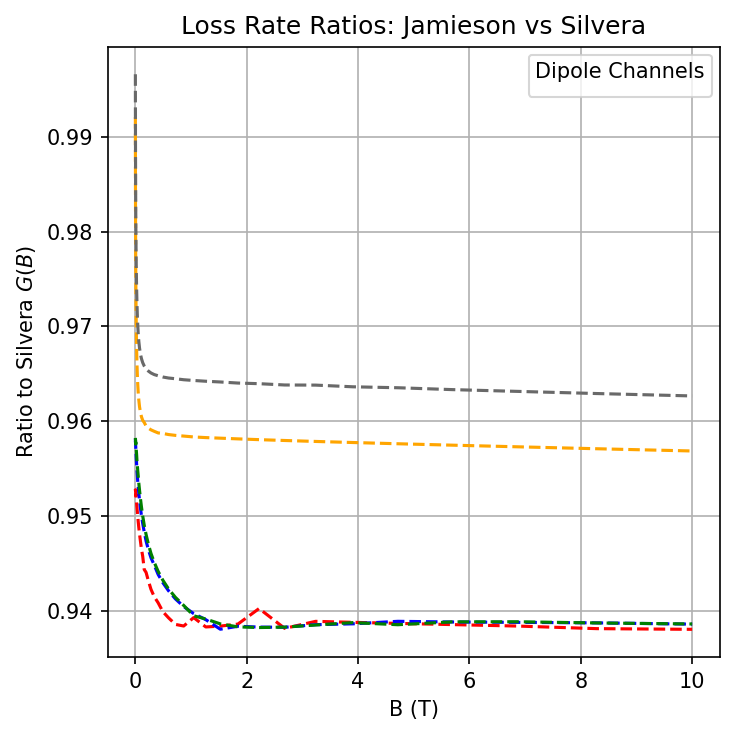

In [31]:
colors = ['red', 'blue', 'green', 'orange', 'dimgrey']
linetypes = ['-', '-.', '--', ':']

for pi, pot_key in enumerate(potentials.TripletsT.keys()):
    print(f"\n=== {pot_key} / {base_key} (Dipole) ===")
    plt.figure(figsize=(5, 5), dpi=150)

    for ci, c in enumerate(DipoleChannels):
        channel_str = str(c)
        ratios = np.asarray(G_factor_ratios_adiabaticDip[pot_key][channel_str], dtype=float)
        ratios[~np.isfinite(ratios)] = np.nan 

        mean_ratio = np.nanmean(ratios)
        std_ratio  = np.nanstd(ratios)
        print(f"Channel {ci+1} ({channel_str}): mean = {mean_ratio:.4f}, std = {std_ratio:.4f}")

        label = f"Channel {ci+1}" if pi == 0 else None  
        plt.plot(B_values, ratios,
                 linetypes[pi % len(linetypes)],
                 color=colors[ci % len(colors)],
                 label=label)
    plt.xlabel("B (T)")
    plt.ylabel(f"Ratio to {base_key} $G(B)$")
    plt.title(f"Loss Rate Ratios: {pot_key} vs {base_key}")
    plt.grid(True, which='both')
    plt.legend(title="Dipole Channels", fontsize=8)
    plt.tight_layout()
    plt.show()

In [33]:
pots = {"Jamieson_Triplet_VDW": potentials.Jamieson_Triplet_VDW,
        "Jamieson_Triplet_HFD": potentials.Jamieson_Triplet_HFD}

G_factors_raw_two = {k: {} for k in pots.keys()}

for pot_key, pot in pots.items():
    for c in DipoleChannels:
        channel_str = str(c)
        losses = np.asarray([
            dipolelosses.GetGFactor(c, B, constants.TritiumConstants(), T, pot, rhos)
            for B in B_values], dtype=float)
        
        G_factors_raw_two[pot_key][channel_str] = losses

ratio_VDW_over_HFD = {}
for c in DipoleChannels:
    channel_str = str(c)
    num = G_factors_raw_two["Jamieson_Triplet_VDW"][channel_str]
    den = G_factors_raw_two["Jamieson_Triplet_HFD"][channel_str]
    ratio = num / den
    ratio_VDW_over_HFD[channel_str] = ratio


=== Dipole Loss Ratio: Jamieson_Triplet_VDW / Jamieson_Triplet_HFD ===
Channel 1 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 1.0067, std = 0.0003
Channel 2 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 1.0065, std = 0.0005
Channel 3 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'd'}): mean = 1.0064, std = 0.0006
Channel 4 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'c'}): mean = 1.0045, std = 0.0015
Channel 5 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'd'}): mean = 1.0037, std = 0.0014


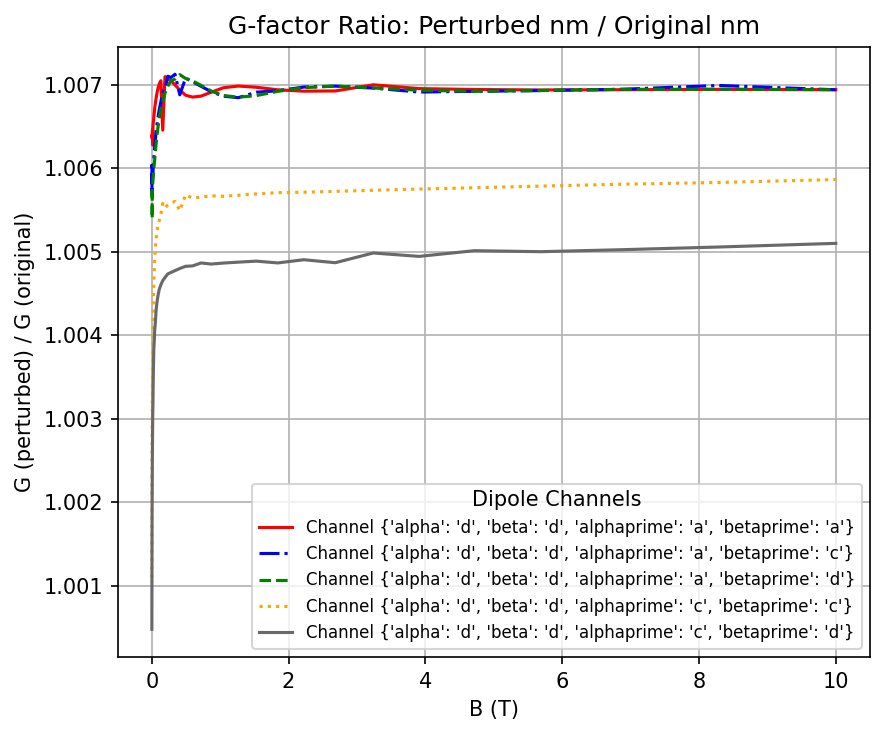

In [34]:
print("\n=== Dipole Loss Ratio: Jamieson_Triplet_VDW / Jamieson_Triplet_HFD ===")
for i, c in enumerate(DipoleChannels, start=1):
    channel_str = str(c)
    r = ratio_VDW_over_HFD[channel_str]
    mean_r = float(np.mean(r))
    std_r  = float(np.std(r))
    print(f"Channel {i} ({channel_str}): mean = {mean_r:.4f}, std = {std_r:.4f}")
    
plt.figure(figsize=(6,5), dpi=150)
for i, c in enumerate(DipoleChannels):
    channel_str = str(c)
    plt.plot(B_values,ratio_VDW_over_HFD[channel_str],
             linetypes[i % len(linetypes)],
             color=colors[i % len(colors)],
             label=f"Channel {channel_str}")

plt.xlabel("B (T)")
plt.ylabel("G (perturbed) / G (original)")
plt.title("G-factor Ratio: Perturbed nm / Original nm")
plt.grid(True, which="both")
plt.legend(title="Dipole Channels", fontsize=8)
plt.tight_layout()
plt.show()

In [40]:
def get_perturbed_resultsDip(attr_name, delta):
    consts = constants.TritiumConstants()
    orig_val = getattr(consts, attr_name)
    setattr(consts, attr_name, orig_val + delta)
    results = {}
    for c in DipoleChannels:
        Gs = []
        for B in B_values:
            Gs.append(
                dipolelosses.GetGFactor(c, B, consts, T, potentials.Silvera_Triplet, rhos,
                    lin=0, lout=2))
        results[str(c)] = np.array(Gs)

    return results
attr_to_perturb = "mu"                 
delta_value = constants.meeV / 2   
G_perturbed = get_perturbed_resultsDip(attr_to_perturb, delta_value)

original = G_factors_rawDip["Silvera"]

Channel {'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'a'}: mean = 1.0040, std = 0.0018
Channel {'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'c'}: mean = 1.0036, std = 0.0011
Channel {'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'd'}: mean = 1.0037, std = 0.0006
Channel {'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'c'}: mean = 1.0025, std = 0.0008
Channel {'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'd'}: mean = 1.0022, std = 0.0007


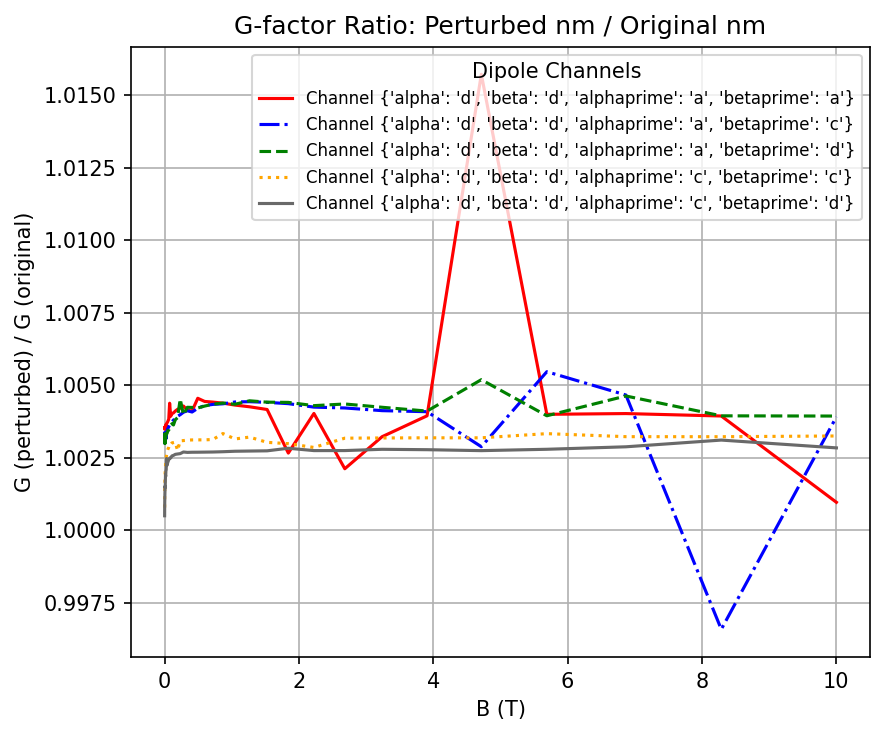

In [43]:
ratio_vs_unperturbed = {}

for channel_str in original.keys():
    unperturbed = np.asarray(original[channel_str], dtype=float)
    perturbed   = np.asarray(G_perturbed[channel_str], dtype=float)

    ratio = perturbed / unperturbed
    ratio_vs_unperturbed[channel_str] = ratio

    mean_ratio = np.nanmean(ratio)
    std_ratio  = np.nanstd(ratio)
    print(f"Channel {channel_str}: mean = {mean_ratio:.4f}, std = {std_ratio:.4f}")

plt.figure(figsize=(6, 5), dpi=150)
for i, (channel_str, ratio) in enumerate(ratio_vs_unperturbed.items()):
    plt.plot(B_values, ratio,
             label=f"Channel {channel_str}",
             linestyle=linetypes[i % len(linetypes)],
             color=colors[i % len(colors)])

plt.xlabel("B (T)")
plt.ylabel("G (perturbed) / G (original)")
plt.title("G-factor Ratio: Perturbed nm / Original nm")
plt.grid(True, which="both")
plt.legend(title="Dipole Channels", fontsize=8)
plt.tight_layout()
plt.show()


In [44]:
potS = potentials.Kolos_Singlet2_VDW

G_factors_raw_SETrip = {}
G_factor_ratios_SETrip = {}

base_key = "Silvera"
base_potential = potentials.Triplets[base_key]

base_losses_by_channel = {}
for c in SpinExChannels:
    channel_str = str(c)
    base_losses_by_channel[channel_str] = np.array([spinexchange.GetGFactor(c, B, constants.TritiumConstants(), T, base_potential, potS, rhos)
        for B in B_values])

for pot_key, potT in potentials.Triplets.items():
    G_factors_raw_SETrip[pot_key] = {}
    G_factor_ratios_SETrip[pot_key] = {}

    for c in SpinExChannels:
        channel_str = str(c)
        losses = np.array([spinexchange.GetGFactor(c, B, constants.TritiumConstants(), T, potT, potS, rhos)
            for B in B_values])

        G_factors_raw_SETrip[pot_key][channel_str] = losses
        G_factor_ratios_SETrip[pot_key][channel_str] = losses / base_losses_by_channel[channel_str]


=== Kolos 74 / Silvera ===
Channel 1 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 0.9677, std = 0.0478
Channel 2 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 0.9814, std = 0.0267
Channel 3 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}): mean = 0.9872, std = 0.0304


/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_8996/1112294864.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="SpinEx Channels", fontsize=8)


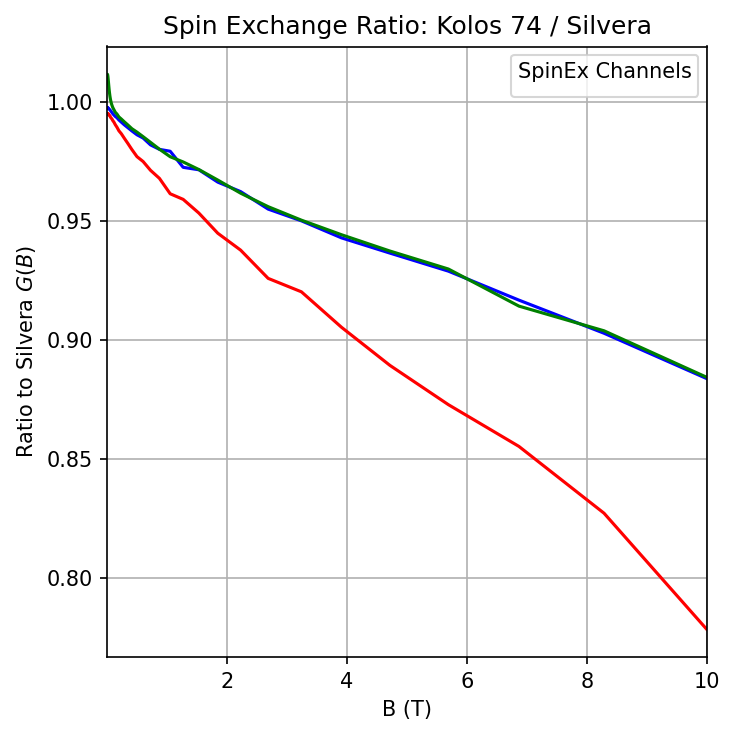


=== Silvera / Silvera ===
Channel 1 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 1.0000, std = 0.0000
Channel 2 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 1.0000, std = 0.0000
Channel 3 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}): mean = 1.0000, std = 0.0000


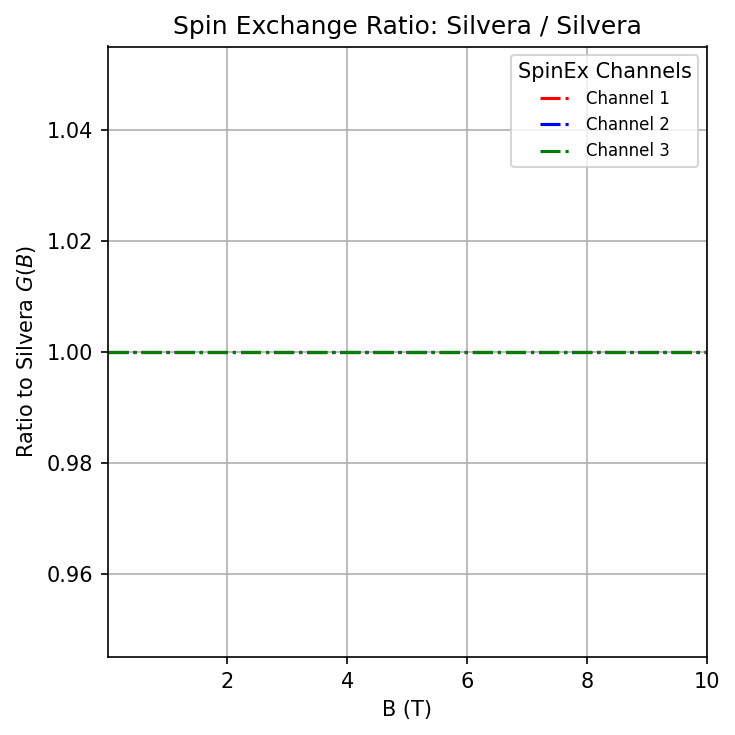


=== Jamieson / Silvera ===
Channel 1 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 0.9446, std = 0.0524
Channel 2 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 0.9623, std = 0.0329
Channel 3 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}): mean = 0.9996, std = 0.0669


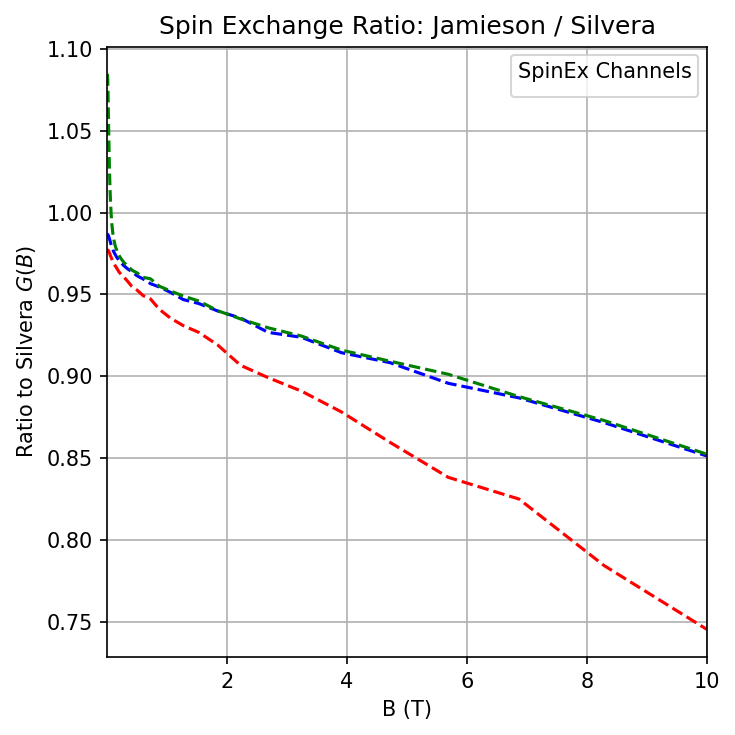

In [45]:
for pi, pot_key in enumerate(potentials.Triplets.keys()):
    print(f"\n=== {pot_key} / {base_key} ===")
    plt.figure(figsize=(5, 5), dpi=150)

    for ci, c in enumerate(SpinExChannels):
        channel_str = str(c)
        ratios = np.asarray(G_factor_ratios_SETrip[pot_key][channel_str], dtype=float)
        mean_ratio = np.nanmean(ratios)
        std_ratio  = np.nanstd(ratios)
        print(f"Channel {ci+1} ({channel_str}): mean = {mean_ratio:.4f}, std = {std_ratio:.4f}")
        
        label = f"Channel {ci+1}" if pi == 1 else None  
        plt.plot(B_values,ratios,
                 linetypes[pi % len(linetypes)],
                 color=colors[ci % len(colors)],
                 label=label)

    plt.xlabel("B (T)")
    plt.xlim(0.001, 10)
    plt.ylabel(f"Ratio to {base_key} $G(B)$")
    plt.title(f"Spin Exchange Ratio: {pot_key} / {base_key}")
    plt.grid(True, which='both')
    plt.legend(title="SpinEx Channels", fontsize=8)
    plt.tight_layout()
    plt.show()

In [47]:
potT = potentials.Silvera_Triplet

G_factors_raw_SESing   = {}
G_factor_ratios_SESing = {}

base_key       = "Kolos 74"
base_potential = potentials.Singlets[base_key]

base_losses_by_channel = {}
for c in SpinExChannels:
    ch = str(c)
    base_losses_by_channel[ch] = np.asarray([
        spinexchange.GetGFactor(c, B, constants.TritiumConstants(), T, potT, base_potential, rhos)
        for B in B_values
    ], dtype=float)

for pot_key, potS in potentials.Singlets.items():
    G_factors_raw_SESing[pot_key]   = {}
    G_factor_ratios_SESing[pot_key] = {}

    for c in SpinExChannels:
        ch = str(c)
        losses = np.asarray([spinexchange.GetGFactor(c, B, constants.TritiumConstants(), T, potT, potS, rhos)
                             for B in B_values], dtype=float)

        G_factors_raw_SESing[pot_key][ch]   = losses
        G_factor_ratios_SESing[pot_key][ch] = losses / base_losses_by_channel[ch]


=== Kolos 74 / Kolos 74 ===
Channel 1 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 1.0000, std = 0.0000
Channel 2 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 1.0000, std = 0.0000
Channel 3 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}): mean = 1.0000, std = 0.0000


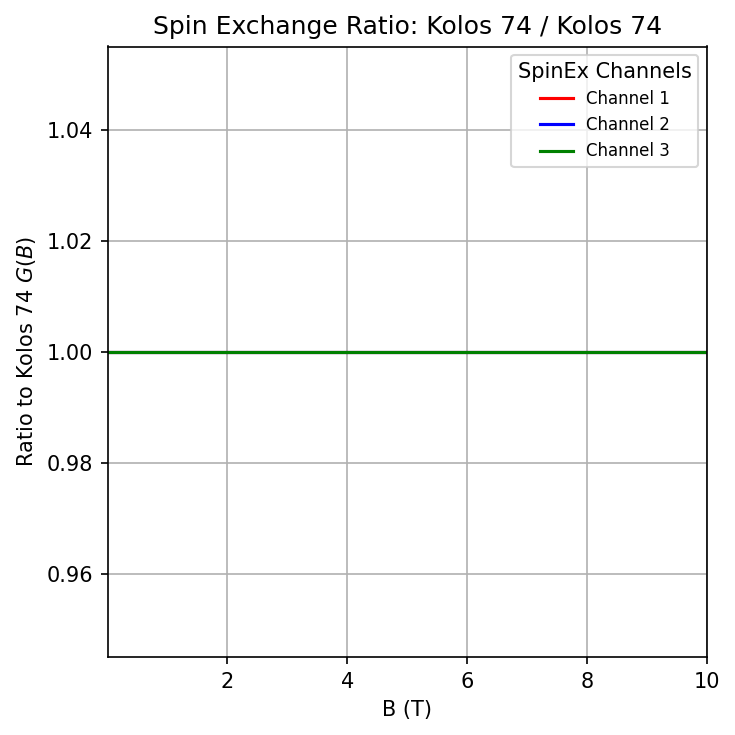


=== Wolniewicz / Kolos 74 ===
Channel 1 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 1.3245, std = 0.1806
Channel 2 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 1.2391, std = 0.1914
Channel 3 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}): mean = 1.1495, std = 0.2651


/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_8996/574374275.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="SpinEx Channels", fontsize=8)


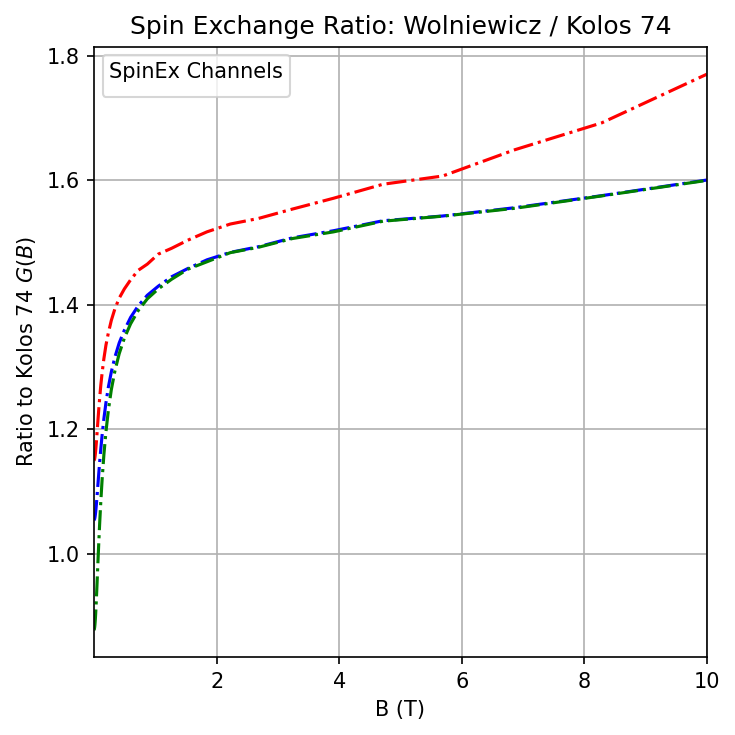


=== Jamieson / Kolos 74 ===
Channel 1 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 1.6109, std = 0.3973
Channel 2 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 1.4427, std = 0.3973
Channel 3 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}): mean = 1.3032, std = 0.5055


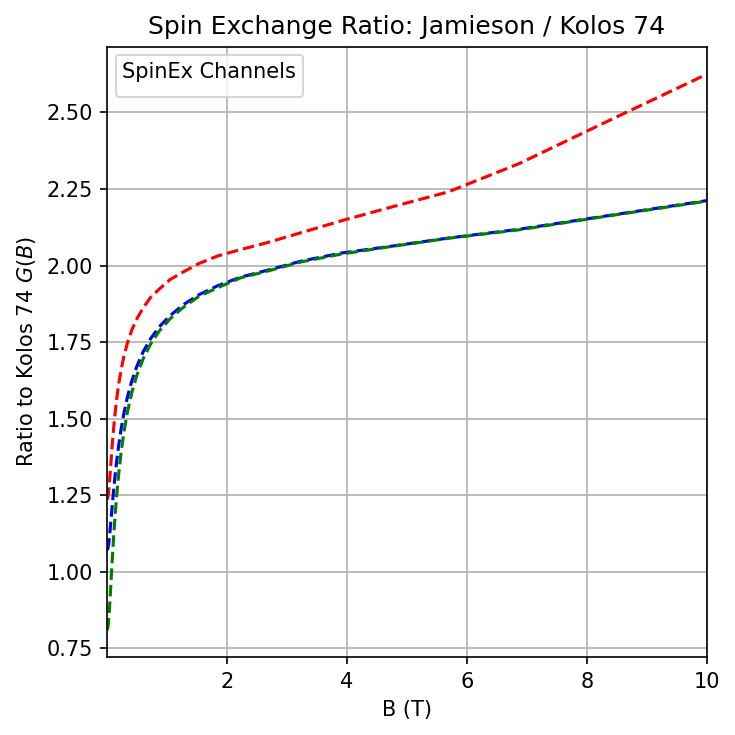

In [49]:
for pi, (pot_key, ch_map) in enumerate(G_factor_ratios_SESing.items()):
    print(f"\n=== {pot_key} / {base_key} ===")
    plt.figure(figsize=(5, 5), dpi=150)

    for ci, c in enumerate(SpinExChannels):
        channel_str = str(c)
        ratios = np.asarray(ch_map[channel_str], dtype=float)

        mean_ratio = np.mean(ratios)
        std_ratio  = np.std(ratios)

        print(f"Channel {ci+1} ({channel_str}): mean = {mean_ratio:.4f}, std = {std_ratio:.4f}")

        label = f"Channel {ci+1}" if pi == 0 else None
        plt.plot(
            B_values,
            ratios,
            linetypes[pi % len(linetypes)],
            color=colors[ci % len(colors)],
            label=label
        )

    plt.xlabel("B (T)")
    plt.xlim(0.001, 10)
    plt.ylabel(f"Ratio to {base_key} $G(B)$")
    plt.title(f"Spin Exchange Ratio: {pot_key} / {base_key}")
    plt.grid(True, which='both')
    plt.legend(title="SpinEx Channels", fontsize=8)
    plt.tight_layout()
    plt.show()


In [50]:
label_pert = "Potential_Perturbation"
G_factors_raw_SETrip[label_pert] = {}
G_factor_ratios_SETrip[label_pert] = {}

for c in SpinExChannels:
    ch = str(c)
    pert_losses = np.array([
        spinexchange.GetGFactor(c, B, constants.TritiumConstants(), T,
                                Potential_Perturbation, potS, rhos)
        for B in B_values
    ])
    G_factors_raw_SETrip[label_pert][ch] = pert_losses
    base_losses = base_losses_by_channel[ch]
    ratio = base_losses / pert_losses
    G_factor_ratios_SETrip[label_pert][ch] = ratio


=== Silvera / Potential_Perturbation ===
Channel 1 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 0.6586, std = 0.1449
Channel 2 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 0.7451, std = 0.1831
Channel 3 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}): mean = 0.8757, std = 0.2988


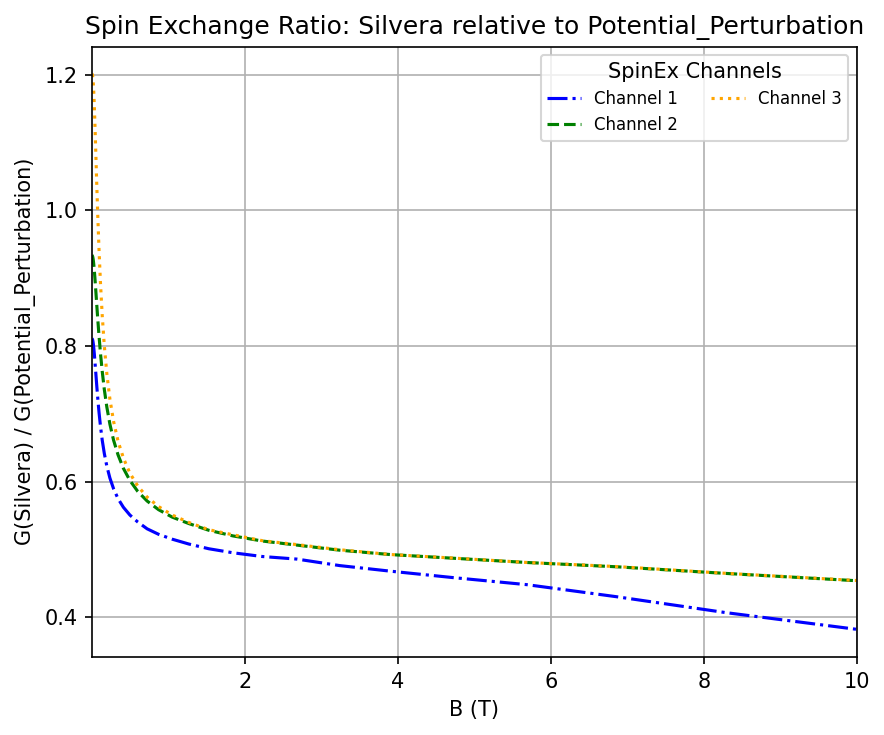

In [52]:
print(f"\n=== Silvera / {label_pert} ===")
plt.figure(figsize=(6, 5), dpi=150)

for i, c in enumerate(SpinExChannels, start=1):
    ch = str(c)

    r = np.asarray(G_factor_ratios_SETrip[label_pert][ch], dtype=float)
    r[~np.isfinite(r)] = np.nan

    mean_r = float(np.nanmean(r))
    std_r  = float(np.nanstd(r))
    print(f"Channel {i} ({ch}): mean = {mean_r:.4f}, std = {std_r:.4f}")

    plt.plot(B_values, r,
             linetypes[i % len(linetypes)],
             color=colors[i % len(colors)],
             label=f"Channel {i}")

plt.xlabel("B (T)")
plt.xlim(0.001, 10)
plt.ylabel(f"G(Silvera) / G({label_pert})")
plt.title(f"Spin Exchange Ratio: Silvera relative to {label_pert}")
plt.grid(True, which="both")
plt.legend(title="SpinEx Channels", fontsize=8, ncol=2)
plt.tight_layout()
plt.show()


In [54]:
def Singlet_Perturbation(R):
    x = R * constants.hcInEVAngstrom / 4.16
    return (1 + .001*x) * potentials.Jamieson_Singlet_VDW(R)

In [56]:
potT = potentials.Silvera_Triplet
label_pert = "Singlet_Perturbation"   
singlet_pert = Singlet_Perturbation

base_key = "Kolos 74"

G_factors_raw_SESing[label_pert]   = {}
G_factor_ratios_SESing[label_pert] = {}

for c in SpinExChannels:
    ch = str(c)
    losses = np.asarray([spinexchange.GetGFactor(c, B, constants.TritiumConstants(), T, potT, singlet_pert, rhos)
                         for B in B_values], dtype=float)

    G_factors_raw_SESing[label_pert][ch]   = losses
    G_factor_ratios_SESing[label_pert][ch] = losses / G_factors_raw_SESing[base_key][ch]



=== Singlet_Perturbation / Kolos 74 ===
Channel 1 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 1.7249, std = 0.4938
Channel 2 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 1.5228, std = 0.4859
Channel 3 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}): mean = 1.3675, std = 0.6039


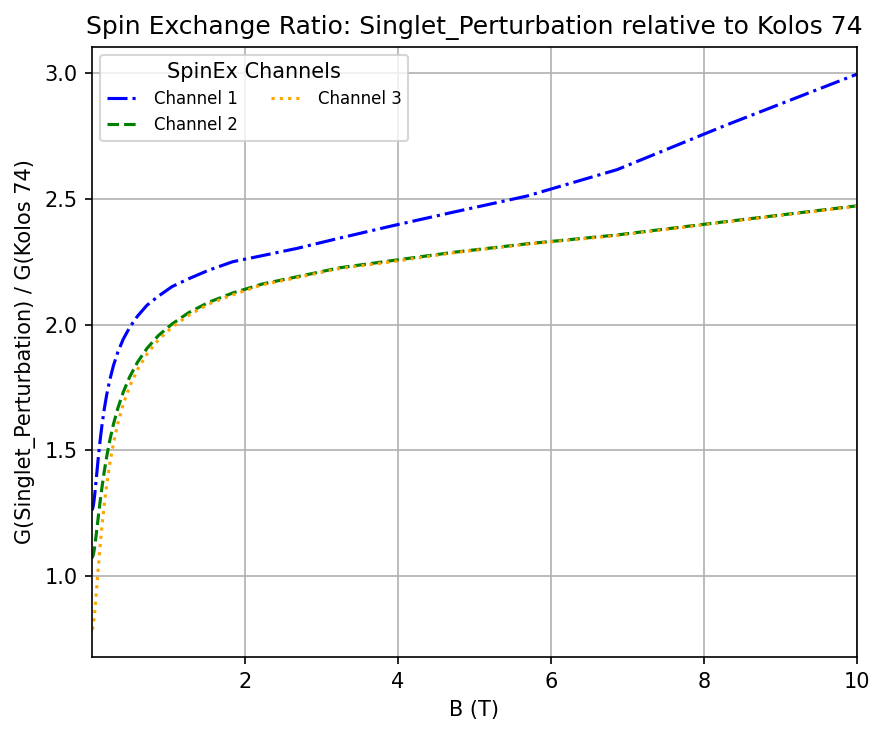

In [57]:
print(f"\n=== {label_pert} / {base_key} ===")
plt.figure(figsize=(6, 5), dpi=150)

for i, c in enumerate(SpinExChannels, start=1):
    ch = str(c)
    r = np.asarray(G_factor_ratios_SESing[label_pert][ch], dtype=float)
    r[~np.isfinite(r)] = np.nan

    mean_r = float(np.nanmean(r))
    std_r  = float(np.nanstd(r))
    print(f"Channel {i} ({ch}): mean = {mean_r:.4f}, std = {std_r:.4f}")

    plt.plot(B_values, r,
             linetypes[i % len(linetypes)],
             color=colors[i % len(colors)],
             label=f"Channel {i}")

plt.xlabel("B (T)")
plt.xlim(0.001, 10)
plt.ylabel(f"G({label_pert}) / G({base_key})")
plt.title(f"Spin Exchange Ratio: {label_pert} relative to {base_key}")
plt.grid(True, which="both")
plt.legend(title="SpinEx Channels", fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

In [59]:
def get_perturbed_resultsEx(attr_name, delta):
    consts = constants.TritiumConstants()
    orig_val = getattr(consts, attr_name)
    setattr(consts, attr_name, orig_val + delta)

    results = {}
    for c in SpinExChannels:
        Gs = []
        for B in B_values:
            Gs.append(spinexchange.GetGFactor(c, B, consts, T,
                                              potentials.Silvera_Triplet,
                                              potentials.Kolos_Singlet2_VDW,
                                              rhos))
        results[str(c)] = np.asarray(Gs, dtype=float)     
    return results

attr_to_perturb = "mu"
delta_value     = constants.meeV / 2
G_perturbedEx   = get_perturbed_resultsEx(attr_to_perturb, delta_value)


Channel {'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}: mean = 1.0560, std = 0.0254
Channel {'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}: mean = 1.0419, std = 0.0284
Channel {'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}: mean = 1.0234, std = 0.0448


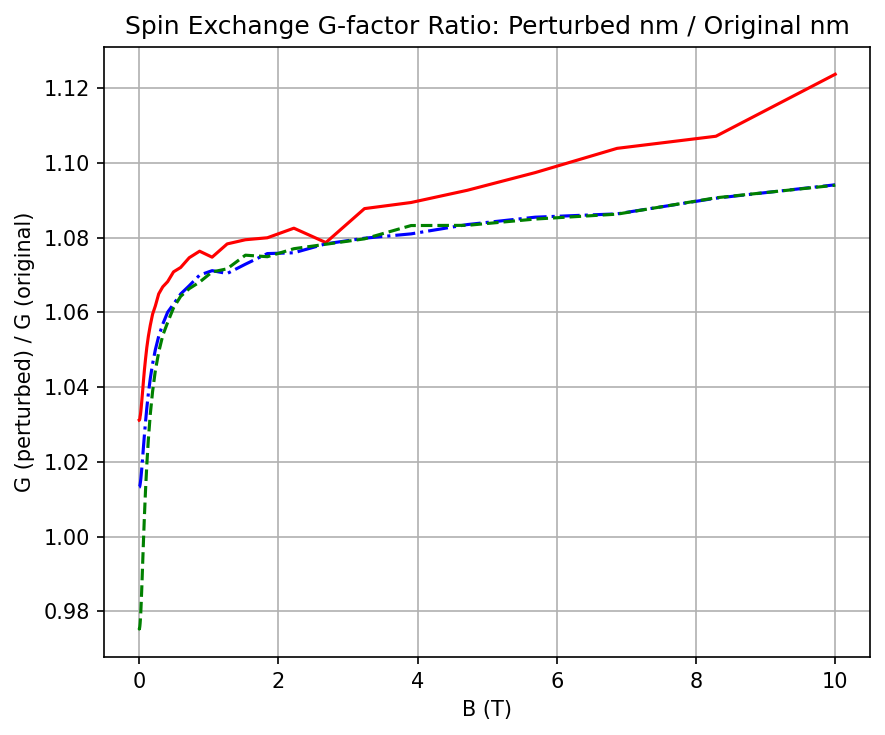

In [61]:
ratio_vs_unperturbedEx = {}

originalEx = G_factors_raw_SESing["Kolos 74"]   
for ch in originalEx.keys():
    unperturbed = np.asarray(originalEx[ch], dtype=float)
    perturbed   = np.asarray(G_perturbedEx[ch], dtype=float)
    ratio       = perturbed / unperturbed
    ratio_vs_unperturbedEx[ch] = ratio

    mean_ratio = float(np.nanmean(ratio))
    std_ratio  = float(np.nanstd(ratio))
    print(f"Channel {ch}: mean = {mean_ratio:.4f}, std = {std_ratio:.4f}")

plt.figure(figsize=(6, 5), dpi=150)
for i, (ch, ratio) in enumerate(ratio_vs_unperturbedEx.items()):
    plt.plot(B_values, ratio,
             label=f"Channel {ch}",
             linestyle=linetypes[i % len(linetypes)],
             color=colors[i % len(colors)])

plt.xlabel("B (T)")
plt.ylabel("G (perturbed) / G (original)")
plt.title("Spin Exchange G-factor Ratio: Perturbed nm / Original nm")
plt.grid(True, which="both")
#plt.legend(title="SpinEx Channels", fontsize=8, ncol=2)
plt.tight_layout()
plt.show()


In [68]:
potS = potentials.Kolos_Singlet2_VDW

G_factors_raw_adiabaticTrip = {}
G_factor_ratios_adiabaticTrip = {}

for pot_key, potT in potentials.TripletsT.items():
    G_factors_raw_adiabaticTrip[pot_key] = {}
    G_factor_ratios_adiabaticTrip[pot_key] = {}

    for c in SpinExChannels:
        channel_str = str(c)
        losses = np.array([spinexchange.GetGFactor(c, B, constants.TritiumConstants(), T, potT, potS, rhos)
            for B in B_values])

        G_factors_raw_adiabaticTrip[pot_key][channel_str] = losses
        G_factor_ratios_adiabaticTrip[pot_key][channel_str] = losses / G_factors_raw_SETrip[pot_key][channel_str]


=== Kolos 74 (adiabatic / non-adiabatic) ===
Channel 1 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 0.9615, std = 0.0475
Channel 2 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 0.9759, std = 0.0277
Channel 3 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}): mean = 0.9913, std = 0.0397


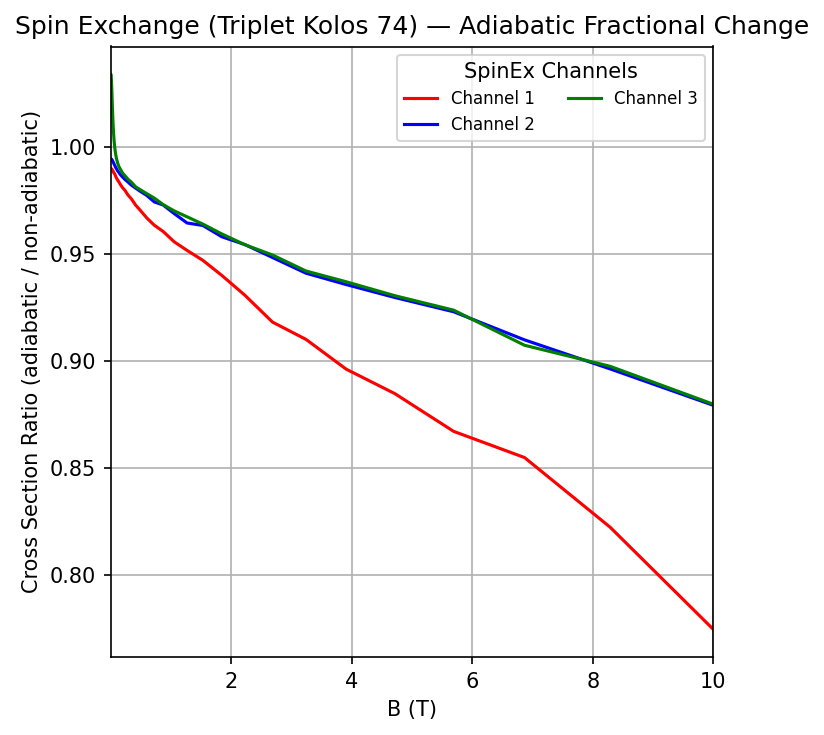


=== Silvera (adiabatic / non-adiabatic) ===
Channel 1 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 0.9936, std = 0.0021
Channel 2 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 0.9944, std = 0.0021
Channel 3 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}): mean = 1.0041, std = 0.0126


/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_8996/4012908057.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="SpinEx Channels", fontsize=8, ncol=2)


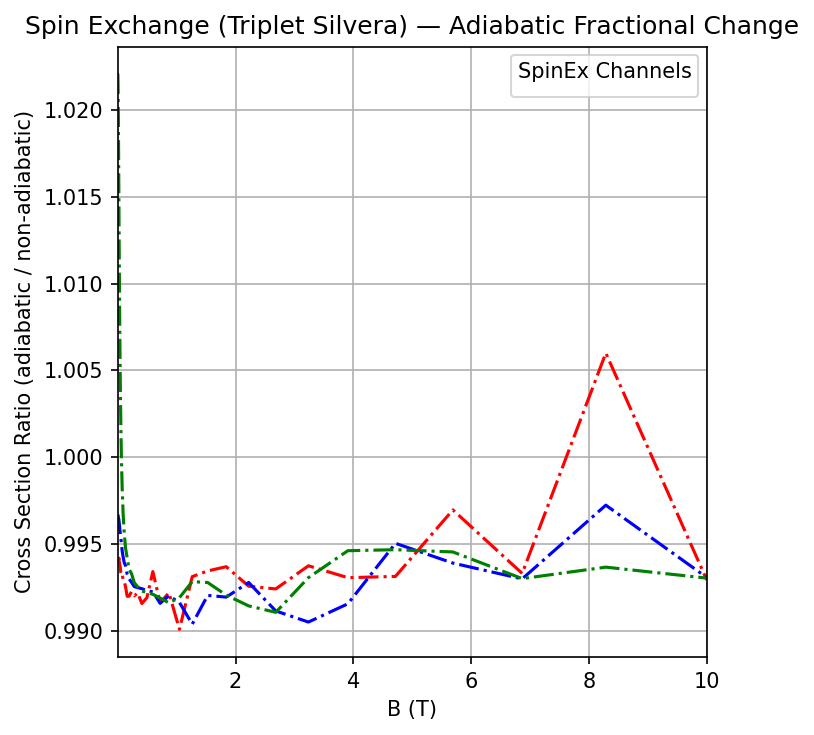


=== Jamieson (adiabatic / non-adiabatic) ===
Channel 1 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 1.0140, std = 0.0024
Channel 2 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 1.0119, std = 0.0041
Channel 3 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}): mean = 0.9924, std = 0.0258


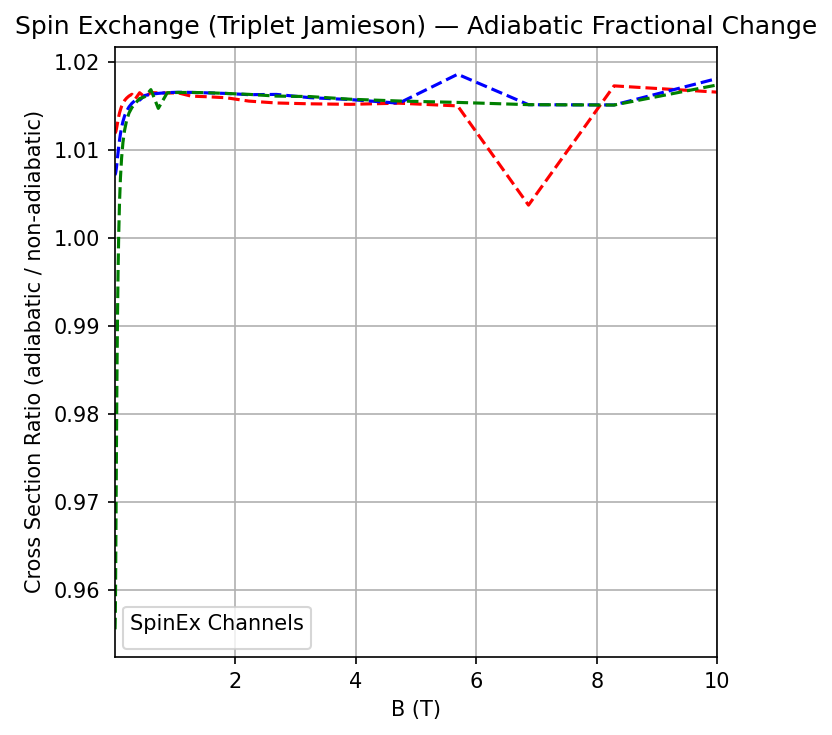

In [69]:
for pi, pot_key in enumerate(G_factor_ratios_adiabaticTrip.keys()):
    print(f"\n=== {pot_key} (adiabatic / non-adiabatic) ===")
    plt.figure(figsize=(5, 5), dpi=150)

    for ci, c in enumerate(SpinExChannels):
        channel_str = str(c)

        ratios = np.asarray(G_factor_ratios_adiabaticTrip[pot_key][channel_str], dtype=float)
        ratios[~np.isfinite(ratios)] = np.nan  
        mean_ratio = float(np.nanmean(ratios))
        std_ratio  = float(np.nanstd(ratios))
        print(f"Channel {ci+1} ({channel_str}): mean = {mean_ratio:.4f}, std = {std_ratio:.4f}")

        label = f"Channel {ci+1}" if pi == 0 else None
        plt.plot(B_values,ratios,
                 linetypes[pi % len(linetypes)],
                 color=colors[ci % len(colors)],
                 label=label)

    plt.xlabel("B (T)")
    plt.xlim(0.001, 10)
    plt.ylabel("Cross Section Ratio (adiabatic / non-adiabatic)")
    plt.title(f"Spin Exchange (Triplet {pot_key}) — Adiabatic Fractional Change")
    plt.grid(True, which='both')
    plt.legend(title="SpinEx Channels", fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()


In [64]:
potT = potentials.Silvera_Triplet

G_factors_raw_adiabaticSing   = {}
G_factor_ratios_adiabaticSing = {}

for pot_key, potS in potentials.SingletsT.items():
    G_factors_raw_adiabaticSing[pot_key]   = {}
    G_factor_ratios_adiabaticSing[pot_key] = {}

    for c in SpinExChannels:
        ch = str(c)
        losses = np.asarray([spinexchange.GetGFactor(c, B, constants.TritiumConstants(), T, potT, potS, rhos)
                             for B in B_values], dtype=float)

        G_factors_raw_adiabaticSing[pot_key][ch]   = losses
        G_factor_ratios_adiabaticSing[pot_key][ch] = losses / G_factors_raw_SESing[pot_key][ch]


=== Kolos 74 (adiabatic / non-adiabatic, Singlet) ===
Channel 1 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 0.9432, std = 0.0223
Channel 2 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 0.9567, std = 0.0262
Channel 3 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}): mean = 0.9788, std = 0.0464


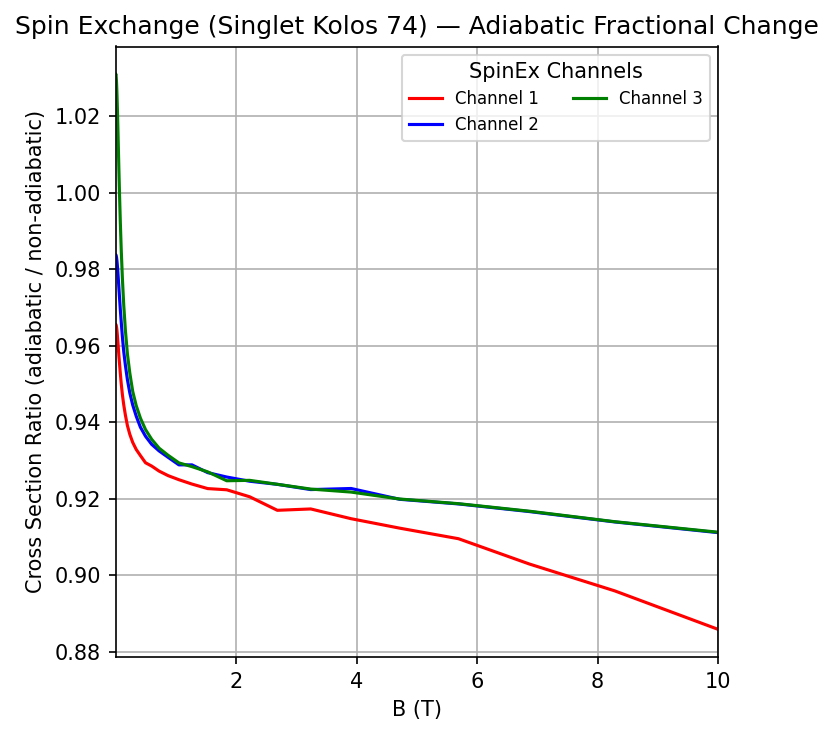


=== Wolniewicz (adiabatic / non-adiabatic, Singlet) ===
Channel 1 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 1.0828, std = 0.0462
Channel 2 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 1.0601, std = 0.0515
Channel 3 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}): mean = 1.0361, std = 0.0711


/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_8996/3063833551.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="SpinEx Channels", fontsize=8, ncol=2)


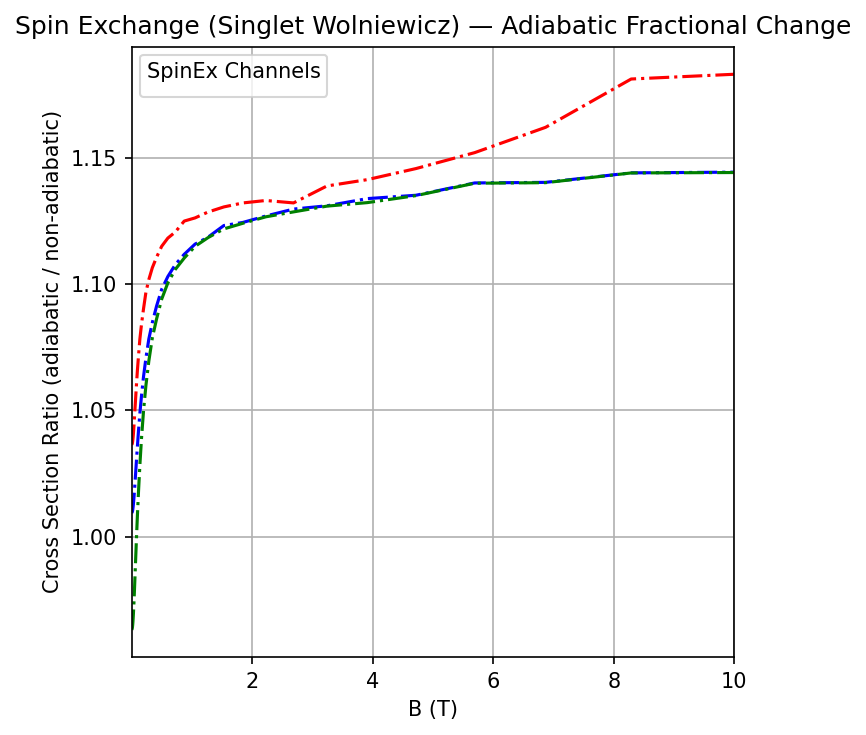


=== Jamieson (adiabatic / non-adiabatic, Singlet) ===
Channel 1 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 1.0644, std = 0.0417
Channel 2 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 1.0459, std = 0.0456
Channel 3 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}): mean = 1.0294, std = 0.0587


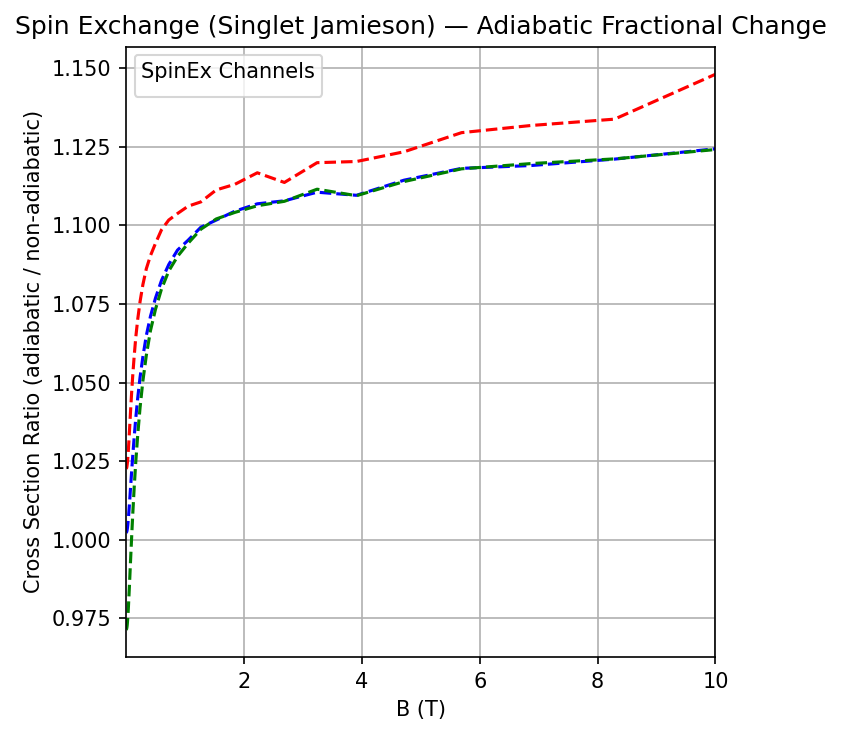

In [65]:
for pi, pot_key in enumerate(G_factor_ratios_adiabaticSing.keys()):
    print(f"\n=== {pot_key} (adiabatic / non-adiabatic, Singlet) ===")
    plt.figure(figsize=(5, 5), dpi=150)

    for ci, c in enumerate(SpinExChannels):
        ch = str(c)
        ratios = np.asarray(G_factor_ratios_adiabaticSing[pot_key][ch], dtype=float)
        ratios[~np.isfinite(ratios)] = np.nan  

        mean_ratio = float(np.nanmean(ratios))
        std_ratio  = float(np.nanstd(ratios))
        print(f"Channel {ci+1} ({ch}): mean = {mean_ratio:.4f}, std = {std_ratio:.4f}")

        label = f"Channel {ci+1}" if pi == 0 else None
        plt.plot(B_values, ratios,
                 linetypes[pi % len(linetypes)],
                 color=colors[ci % len(colors)],
                 label=label)

    plt.xlabel("B (T)")
    plt.xlim(0.001, 10)
    plt.ylabel("Cross Section Ratio (adiabatic / non-adiabatic)")
    plt.title(f"Spin Exchange (Singlet {pot_key}) — Adiabatic Fractional Change")
    plt.grid(True, which='both')
    plt.legend(title="SpinEx Channels", fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()


In [75]:
potS = potentials.Kolos_Singlet2_VDW

G_factors_raw_trip_extrap   = {}
G_factor_ratios_trip_extrap = {}

num_key = "Jamieson_Triplet_VDW"
den_key = "Jamieson"
G_factors_raw_trip_extrap[num_key] = {}
for c in SpinExChannels:
    ch = str(c)
    vals = [spinexchange.GetGFactor(c, B, constants.TritiumConstants(), T,
                                    potentials.Jamieson_Triplet_VDW, potS, rhos)
            for B in B_values]
    G_factors_raw_trip_extrap[num_key][ch] = np.asarray(vals, dtype=float)

G_factor_ratios_trip_extrap["VDW"] = {}
for c in SpinExChannels:
    ch = str(c)
    num = np.asarray(G_factors_raw_trip_extrap[num_key][ch], dtype=float)
    den = np.asarray(G_factors_raw_SETrip[den_key][ch], dtype=float)  
    ratio = num / den
    G_factor_ratios_trip_extrap["VDW"][ch] = ratio


=== Jamieson_Triplet_VDW / Jamieson (Spin-exchange) ===
Channel 1 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 0.9992, std = 0.0002
Channel 2 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 0.9993, std = 0.0002
Channel 3 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}): mean = 1.0017, std = 0.0029


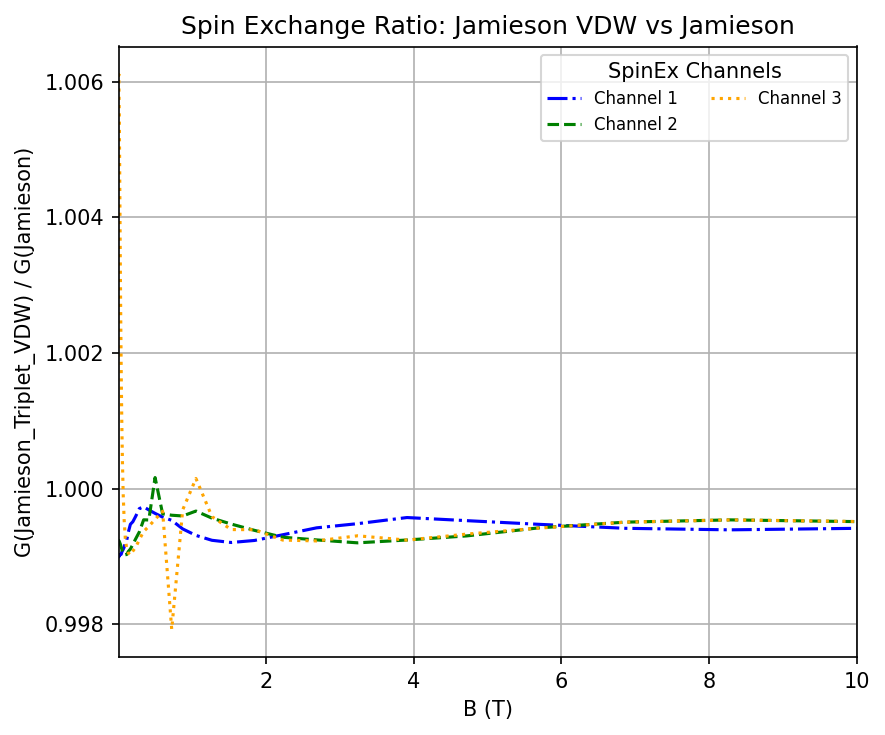

In [76]:
print("\n=== Jamieson_Triplet_VDW / Jamieson (Spin-exchange) ===")
plt.figure(figsize=(6,5), dpi=150)
for i, c in enumerate(SpinExChannels, start=1):
    ch = str(c)
    r = np.asarray(G_factor_ratios_trip_extrap["VDW"][ch], dtype=float)
    r[~np.isfinite(r)] = np.nan

    mean_r = float(np.nanmean(r))
    std_r  = float(np.nanstd(r))
    print(f"Channel {i} ({ch}): mean = {mean_r:.4f}, std = {std_r:.4f}")

    plt.plot(B_values, r,
             linetypes[i % len(linetypes)],
             color=colors[i % len(colors)],
             label=f"Channel {i}")

plt.xlabel("B (T)")
plt.xlim(0.001, 10)
plt.ylabel("G(Jamieson_Triplet_VDW) / G(Jamieson)")
plt.title("Spin Exchange Ratio: Jamieson VDW vs Jamieson")
plt.grid(True, which='both')
plt.legend(title="SpinEx Channels", fontsize=8, ncol=2)
plt.tight_layout()
plt.show()